In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from cooling_class import get_cooling_object
from latexify import latexify
import time
import jax
import jax.numpy as jnp
import jax.nn as jnn
import jax.random as jr
import diffrax
from diffrax import diffeqsolve, ODETerm, SaveAt, Tsit5
import equinox as eqx
import optax
import pysr
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
g_code_units = 0.03741114852 # 1e-8 cm/s^2
cooler = get_cooling_object()

In [4]:
rs = jnp.array([3,1,0.3,1.73,0.55,10,5.5]) # Training Set
rsT = jnp.array([0.7,0.4,0.8,2,4,8])       # Validation Set

In [5]:
# cutoff = 13000 # r1.73
# cutoff = 13000 #r1
# cutoff = 8000 # r0.3
# cutoff = 11000 # r0.55
# cutoff = 9000 # r0.4
# cutoff = 14000 #r0.7 r0.8
cutoffs = [22000,13000,8000,13000,11000,10000,15000]
cutoffsT = [14000,9000,14000,22000,18000,13000]

In [6]:
train_ts = []
train_ys = []
for i in range(len(rs)):
    fr = '/mnt/home/btan1/ceph/falling_cloud/hydro_r'+str(rs[i])
    hst_data = np.loadtxt(fr + "/data/fc.hst")
    c = min(cutoffs[i],np.shape(hst_data)[0])
    train_ts.append(hst_data[:c:int(c/1000), 0])
    train_ys.append(hst_data[:c:int(c/1000),10:13])
train_ts = jnp.array(train_ts)
train_ys = jnp.array(train_ys)

In [7]:
test_ts = []
test_ys = []
for i in range(len(rsT)):
    fr = '/mnt/home/btan1/ceph/falling_cloud/hydro_r'+str(rsT[i])
    hst_data = np.loadtxt(fr + "/data/fc.hst")
    c = min(cutoffsT[i],np.shape(hst_data)[0])
    test_ts.append(hst_data[:c:int(c/1000), 0])
    test_ys.append(hst_data[:c:int(c/1000),10:13])
test_ts = jnp.array(test_ts)
test_ys = jnp.array(test_ys)

In [8]:
m_norm_factor = train_ys[0,0,2]
def normalize(yi):
    return jnp.swapaxes(jnp.array([-1.*yi[:,0], -1.*yi[:,1]/1000, yi[:,2]/m_norm_factor/10]),0,1)

train_ys = jax.vmap(normalize,0)(train_ys)
test_ys  = jax.vmap(normalize,0)(test_ys) 

In [9]:
# input in code units
def get_sol_jax(r, t_array):
    cool_fac = 100
    g        = g_code_units
    chi      = 100
    t_end    = t_array[-1]
    c0       = 1.0
    rho_cold = 100.0
    m0       = rho_cold*(4/3)*jnp.pi*r**3
    cshot    = 1.5*jnp.sqrt(chi/100)
    
    f_A      = 0.234
    tgrow0   = f_A*150*jnp.power(cool_fac/5,-0.25)*(chi/100)*r**0.75

    @jax.jit
    def falling_cloud(t,y,args):
        z,v,m = y
        
        rampup = 5*jnp.sqrt(chi)*r/z
        weight = jnp.where(rampup>1,rampup,1)
        tgrow = weight*tgrow0*jnp.power(m/m0,1/6)*jnp.power(1.5/jnp.where(v<cshot,v,cshot),0.6)

        dzdt = v
        dvdt = -(v/tgrow) + g - ((c0)/(2*chi))*(1/r)*v**2
        dmdt = m/tgrow

        return dzdt, dvdt, dmdt

    term   = ODETerm(falling_cloud)
    solver = Tsit5()
    saveat = SaveAt(ts=t_array)
    sol    = diffeqsolve(term, solver, 0, t_end, 0.1, (1e-20,1e-20,m0), args=(), saveat=saveat)
    
    return jnp.array(sol.ys)

In [10]:
length_size = 1000
t_end       = 225

t_range     = jnp.linspace(0, t_end, length_size)
ts          = jnp.linspace(0, 1.0, length_size)

training_sol = jax.vmap(get_sol_jax, in_axes=(0, 0))(rs, train_ts)
test_sol     = jax.vmap(get_sol_jax, in_axes=(0, 0))(rsT, test_ts)

def normalize2(yi):
    return jnp.swapaxes(jnp.array([yi[1], yi[0]/1000, yi[2]/training_sol[0,2,0]/10]),0,1)

ys = jax.vmap(normalize2,0)(training_sol)
ysT = jax.vmap(normalize2,0)(test_sol)   

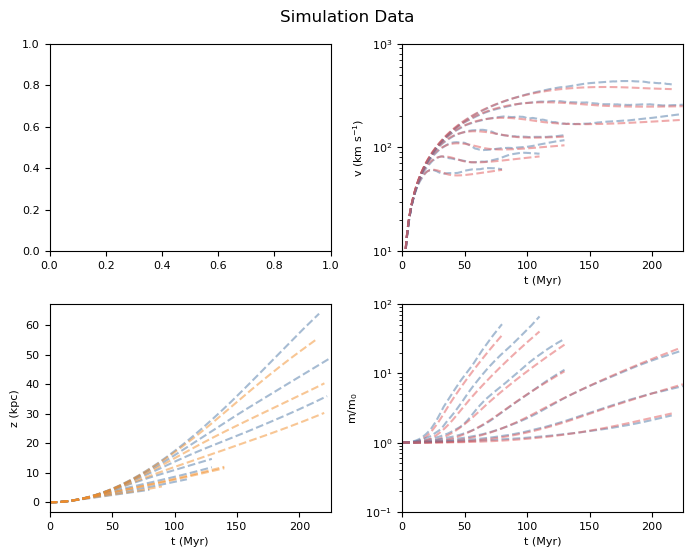

In [11]:
# Create plots
latexify(columns=2)
fig, axs = plt.subplots(2, 2)

for i in range(len(rs)):
    axs[0][1].plot(train_ts[i], 100*train_ys[i,:,0],alpha=0.5,c='C0',ls='--')
    axs[0][1].plot(train_ts[i], 100*ys[i,:,0],alpha=0.5,c='C2',ls='--')
# for i in range(len(rsT)):
    # axs[0][1].plot(test_ts[i], 100*test_ys[i,:,0],alpha=0.5,c='C1',ls='--')
axs[0][1].set_xlim([0,225])
axs[0][1].set_yscale('log')
axs[0][1].set_ylim([0.1*100, 10*100])
axs[0][1].set_xlabel('t (Myr)')
axs[0][1].set_ylabel(r'v (km s$^{-1}$)')

for i in range(len(rs)):
    axs[1][0].plot(train_ts[i], 1000*train_ys[i,:,1]/10,alpha=0.5,c='C0',ls='--')
for i in range(len(rsT)):
    axs[1][0].plot(test_ts[i], 1000*test_ys[i,:,1]/10,alpha=0.5,c='C1',ls='--')
axs[1][0].set_xlim([0,225])
axs[1][0].set_xlabel('t (Myr)')
axs[1][0].set_ylabel('z (kpc)')

for i in range(len(rs)):
    axs[1][1].plot(train_ts[i], train_ys[i,:,2]/train_ys[i,0,2],alpha=0.5,c='C0',ls='--')
    axs[1][1].plot(train_ts[i], ys[i,:,2]/ys[i,0,2],alpha=0.5,c='C2',ls='--')
# for i in range(len(rsT)):
#     axs[1][1].plot(test_ts[i], test_ys[i,:,2]/test_ys[i,0,2],alpha=0.5,c='C1',ls='--')
axs[1][1].set_yscale('log')
axs[1][1].set_xlim([0,225])
axs[1][1].set_ylim([1e-1,1e2])
axs[1][1].set_xlabel('t (Myr)')
axs[1][1].set_ylabel(r'm/m$_0$')

plt.suptitle('Simulation Data')
plt.tight_layout()
plt.show()

In [12]:
def xavier_init(weight: jax.Array, key: jax.random.PRNGKey) -> jax.Array:
  out, in_ = weight.shape
  limit = jnp.sqrt(6.0 / (in_ + out))
  return jax.random.uniform(key, shape=(out, in_), minval=-limit, maxval=limit)

def init_linear_weight(model, init_fn, key):
  is_linear = lambda x: isinstance(x, eqx.nn.Linear)
  get_weights = lambda m: [x.weight
                           for x in jax.tree_util.tree_leaves(m, is_leaf=is_linear)
                           if is_linear(x)]
  weights = get_weights(model)
  new_weights = [init_fn(weight, subkey)
                 for weight, subkey in zip(weights, jax.random.split(key, len(weights)))]

  new_model = eqx.tree_at(get_weights, model, new_weights)
  return new_model

In [13]:
class Func(eqx.Module):
    mlp: eqx.nn.MLP

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.mlp = eqx.nn.MLP(
            in_size=data_size,
            out_size=1,
            width_size=width_size,
            depth=depth,
            activation=jnn.gelu,
            key=key,
        )

    def __call__(self, t, y, args):
        return self.mlp(jnp.array([y[0],y[1],jnp.log10(y[2])]))

In [14]:
class NeuralODE(eqx.Module):
    func: Func

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        model = Func(data_size, width_size, depth, key=key)
        model = init_linear_weight(model, xavier_init, key)
        self.func = model

    def __call__(self, ts, y0, r):
        z_norm   = 0.001
        m_norm   = 0.1
        t_norm   = 1./225
        g        = g_code_units
        cool_fac = 100
        chi      = 100
        c0       = 1.0
        rho_cold = 100.0
        cshot    = 1.5*jnp.sqrt(chi/100)
        f_A      = 0.234
        tgrow0   = t_norm*f_A*150*jnp.power(cool_fac/5,-0.25)*(chi/100)*r**0.75
        
        @jax.jit
        def falling_cloud(t,y,args):
            z,v,m = y
                   
            weight = self.func
            tgrow = (1/weight(t,y,args)[0])*tgrow0*jnp.power(m/m_norm/(r/3)**3, 1/6)\
                    *jnp.power(1.5/jnp.where(v<cshot,v,cshot),0.6)

            dzdt = v*z_norm/t_norm
            dvdt = -v/tgrow + g/t_norm - ((c0)/(2*chi))*(1/r)*jnp.power(v,2)/t_norm
            dmdt = m/tgrow

            return jnp.array([dzdt, dvdt, dmdt])
        
        term   = ODETerm(falling_cloud)
        solver = Tsit5()
        saveat = SaveAt(ts=ts)

        solution = diffeqsolve(term, solver, 
                               ts[0], ts[-1], ts[1]-ts[0], jnp.array([1e-20,1e-23,y0[2]]), args=jnp.log10(r), 
                               stepsize_controller=diffrax.PIDController(rtol=1e-5, atol=1e-8), 
                               max_steps=16**5,
                               saveat=saveat)

        return solution

In [15]:
def main(make_plot=False):
    data_size  = 3
    seed       = 5678
    depth      = 3
    width_size = 32

    key = jr.PRNGKey(seed)
    _, model_key, _ = jr.split(key, 3)
    model = NeuralODE(data_size, width_size, depth, key=model_key)

    @eqx.filter_value_and_grad
    def grad_loss(model, ti, yi, ri):
        y_pred = jax.vmap(model, in_axes=(0, 0, 0))(ti, yi[:, 0], ri)
        (batch_size, y_length, _) = jnp.shape(y_pred.ys)
        focus  = jnp.linspace(1,0.1,y_length)
        wi     = jax.lax.dynamic_slice(yi, (0,0,2), (batch_size,y_length,1))
        w_pred = jax.lax.dynamic_slice(y_pred.ys, (0,0,2), (batch_size,y_length,1))
        return jnp.mean(((jnp.log10(wi) - jnp.log10(w_pred)) ** 2)*focus[:,None])
    
    @eqx.filter_jit
    def validation_loss(model, ti, yi, ri):
        y_pred = jax.vmap(model, in_axes=(0, 0, 0))(ti, yi[:, 0], ri)
        (batch_size, y_length, _) = jnp.shape(y_pred.ys)
        focus  = jnp.linspace(1,0.1,y_length)
        wi     = jax.lax.dynamic_slice(yi, (0,0,2), (batch_size,y_length,1))
        w_pred = jax.lax.dynamic_slice(y_pred.ys, (0,0,2), (batch_size,y_length,1))
        return jnp.mean(((jnp.log10(wi) - jnp.log10(w_pred)) ** 2)*focus[:,None])
    
    @eqx.filter_jit
    def make_step(ti, yi, ri, model, opt_state):
        loss, grads = grad_loss(model, ti, yi, ri)
        updates, opt_state = optim.update(grads, opt_state,params=model)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state
    
    print_every     = 100
    lr_strategy     = (2e-3, 3e-3) 
    steps_strategy  = (1400, 3400)
    length_strategy = (0.2, 1) 
    
    losses = []
    accuracies = []
    
    plot_count = 0
        
    for lr, steps, length in zip(lr_strategy, steps_strategy, length_strategy):
        optim = optax.adamw(lr)
        opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))
        _ts = train_ts[:,: int(length_size * length)]/225
        _ys = train_ys[:, : int(length_size * length), :]
        for step in range(steps):
            start = time.time()
            loss, model, opt_state = make_step(_ts, _ys, rs, model, opt_state)
            end = time.time()
            val_loss = validation_loss(model, test_ts/225, test_ys, rsT)

            if (step % print_every) == 0 or step == steps - 1:
                print(f"Step: {step}, Loss: {loss}, Accuracy: {val_loss}, Computation time: {end - start}")
                losses.append(loss)
                accuracies.append(val_loss)
    
                if make_plot:
                    plt.figure()
                    ax = plt.gca()
                    for i in [0,1,3,4]:
                        sol_current = model(ts, ysT[i,0],  rsT[i])
                        lbl1 = "Truth" if i == 0 else None
                        lbl2 = "Prediction" if i == 0 else None
                        plt.plot(test_ts[i], test_ys[i,:,2]/test_ys[i,0,2],alpha=0.5,label=lbl1,c='C1',ls='--')
                        plt.plot(sol_current.ts*225, sol_current.ys[:,2]/sol_current.ys[0,2],
                                 alpha=0.5,label=lbl2,c='C2')
                    plt.text(.02, .98, f'Length Strategy: {lr} \nStep {step}', 
                             ha='left', va='top', transform=ax.transAxes)
                    plt.yscale('log')
                    plt.xlim([0,t_end])
                    plt.ylim([0.05,10000])
                    plt.xlabel('t (Myr)')
                    plt.ylabel(r'm/m$_0$')
                    plt.legend(frameon=False,handlelength=1.8, loc='lower right',ncols=2)
                    plt.tight_layout()
                    plt.savefig(f'./learning/sim{plot_count:03}.png',dpi=150)
                    plot_count += 1
                    plt.close()
                    
    return model, losses, accuracies

In [16]:
model_jax_nn, model_loss , model_accu = main(make_plot=False)

Step: 0, Loss: 1.693983722361736e-05, Accuracy: 0.07722984999418259, Computation time: 9.578694105148315
Step: 100, Loss: 5.328122369974153e-07, Accuracy: 0.047416094690561295, Computation time: 0.004972696304321289
Step: 200, Loss: 2.7570541760724154e-07, Accuracy: 0.046227097511291504, Computation time: 0.004904508590698242
Step: 300, Loss: 1.8635918763720838e-07, Accuracy: 0.046470772475004196, Computation time: 0.005468606948852539
Step: 400, Loss: 2.076474316936583e-07, Accuracy: 0.04607751592993736, Computation time: 0.005958080291748047
Step: 500, Loss: 1.1486527284887416e-07, Accuracy: 0.04507153108716011, Computation time: 0.005755186080932617
Step: 600, Loss: 1.0292237107023539e-07, Accuracy: 0.04481407627463341, Computation time: 0.0057373046875
Step: 700, Loss: 1.206735049663621e-07, Accuracy: 0.045070525258779526, Computation time: 0.005174875259399414
Step: 800, Loss: 2.0599151184796938e-07, Accuracy: 0.045512136071920395, Computation time: 0.005669355392456055
Step: 900,

In [17]:
eqx.tree_serialise_leaves("model_jax_nn.eqx", model_jax_nn.func)

In [18]:
def compute_human_loss(y_pred,yi):
    (batch_size, y_length, _) = jnp.shape(y_pred)
    focus  = jnp.linspace(1,0.1,y_length)
    wi     = jax.lax.dynamic_slice(yi, (0,0,2), (batch_size,y_length,1))
    w_pred = jax.lax.dynamic_slice(y_pred, (0,0,2), (batch_size,y_length,1))
    return jnp.mean(((jnp.log10(wi) - jnp.log10(w_pred)) ** 2)*focus[:,None])
human_loss_train = compute_human_loss(ys,train_ys)
human_loss_test = compute_human_loss(ysT,test_ys)

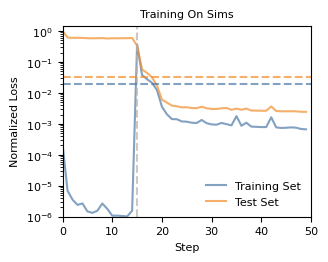

In [19]:
latexify(columns=1)
plt.figure()
plt.yscale('log')
plt.plot(np.array(model_loss)/model_accu[0],alpha=0.7,label='Training Set')
plt.plot(np.array(model_accu)/model_accu[0],alpha=0.7,label='Test Set')
plt.vlines(15,1e-6,5,alpha=0.7,color='C9',ls='--')
plt.hlines(human_loss_train/model_accu[0],0,50,ls='--',alpha=0.7,color='C0')
plt.hlines(human_loss_test/model_accu[0],0,50,ls='--',alpha=0.7,color='C1')
plt.ylabel('Normalized Loss')
plt.xlabel('Step')
plt.xlim(0,50)
plt.ylim(1e-6,1.5)
plt.legend(frameon=False,handlelength=1.8,loc='lower right')
plt.title('Training On Sims')
plt.tight_layout()
plt.savefig('./plots/loss_sims.png',dpi=150)
plt.savefig('./plots/loss_sims.pdf',dpi=150)
plt.show()

In [19]:
sol_jax_nn1 = model_jax_nn(ts, train_ys[0,0],  rs[0])
sol_jax_nn2 = model_jax_nn(ts, train_ys[1,0],  rs[1])
sol_jax_nn3 = model_jax_nn(ts, train_ys[2,0],  rs[2])
sol_jax_nnT = model_jax_nn(ts, test_ys[0,0],  rsT[0])

In [20]:
def get_learned_weights(model_nn, sol_nn,r):
    return jax.vmap(model_nn.func, in_axes=(0, 0, None))(sol_nn.ts,sol_nn.ys,jnp.log10(r))

learn_weights1 = get_learned_weights(model_jax_nn, sol_jax_nn1, rs[0])
learn_weights2 = get_learned_weights(model_jax_nn, sol_jax_nn2, rs[1])
learn_weights3 = get_learned_weights(model_jax_nn, sol_jax_nn3, rs[2])
learn_weightsT = get_learned_weights(model_jax_nn, sol_jax_nnT, rsT[0])

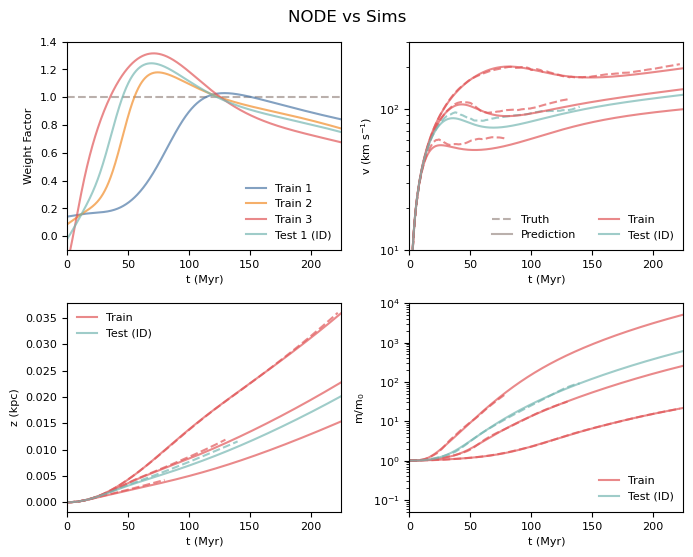

In [22]:
 # Create plots
latexify(columns=2)
fig, axs = plt.subplots(2, 2)

axs[0][0].hlines(1,0,225,ls='--',color='C9')
axs[0][0].plot(t_range, learn_weights1,  c='C0', ls = '-', alpha=0.7,  label=r'Train 1')
axs[0][0].plot(t_range, learn_weights2,  c='C1', ls = '-', alpha=0.7,  label=r'Train 2')
axs[0][0].plot(t_range, learn_weights3,  c='C2', ls = '-', alpha=0.7,  label=r'Train 3')
axs[0][0].plot(t_range, learn_weightsT,  c='C3', ls = '-', alpha=0.7,  label=r'Test 1 (ID)')
axs[0][0].set_ylabel('Weight Factor')
axs[0][0].set_xlabel('t (Myr)')
axs[0][0].set_xlim([0,t_end])
axs[0][0].set_ylim([-0.1,1.4])
axs[0][0].legend(frameon=False,handlelength=1.8, loc='lower right', ncols=1)

axs[0][1].plot(-100, -100, c='C9', ls= '--', label='Truth')
axs[0][1].plot(-100, -100, c='C9', ls= '-', label='Prediction')
axs[0][1].plot(train_ts[0], 100*train_ys[0,:,0],alpha=0.7,c='C2',ls='--')
axs[0][1].plot(train_ts[1], 100*train_ys[1,:,0],alpha=0.7,c='C2',ls='--')
axs[0][1].plot(train_ts[2], 100*train_ys[2,:,0],alpha=0.7,c='C2',ls='--')
axs[0][1].plot(test_ts[0],  100*test_ys[0,:,0], alpha=0.7,c='C3',ls='--')
axs[0][1].plot(t_range, sol_jax_nn1.ys[:,1]*100,alpha=0.7,label="Train",c='C2')
axs[0][1].plot(t_range, sol_jax_nn2.ys[:,1]*100,alpha=0.7,c='C2')
axs[0][1].plot(t_range, sol_jax_nn3.ys[:,1]*100,alpha=0.7,c='C2')
axs[0][1].plot(t_range, sol_jax_nnT.ys[:,1]*100,alpha=0.7,label="Test (ID)",c='C3')
axs[0][1].set_xlim([0,t_end])
axs[0][1].set_yscale('log')
axs[0][1].set_ylim([0.1*100, 3*100])
axs[0][1].set_xlabel('t (Myr)')
axs[0][1].set_ylabel(r'v (km s$^{-1}$)')
axs[0][1].legend(frameon=False,handlelength=1.8,loc='lower right',ncols=2)

axs[1][0].plot(train_ts[0], train_ys[0,:,1]/10,alpha=0.7,c='C2',ls='--')
axs[1][0].plot(train_ts[1], train_ys[1,:,1]/10,alpha=0.7,c='C2',ls='--')
axs[1][0].plot(train_ts[2], train_ys[2,:,1]/10,alpha=0.7,c='C2',ls='--')
axs[1][0].plot(test_ts[0] , test_ys[0,:,1]/10 ,alpha=0.7,c='C3',ls='--')
axs[1][0].plot(t_range, sol_jax_nn1.ys[:,0]/10,alpha=0.7,label="Train",c='C2')
axs[1][0].plot(t_range, sol_jax_nn2.ys[:,0]/10,alpha=0.7,c='C2')
axs[1][0].plot(t_range, sol_jax_nn3.ys[:,0]/10,alpha=0.7,c='C2')
axs[1][0].plot(t_range, sol_jax_nnT.ys[:,0]/10,alpha=0.7,label="Test (ID)",c='C3')
axs[1][0].set_xlim([0,t_end])
axs[1][0].set_xlabel('t (Myr)')
axs[1][0].set_ylabel('z (kpc)')
axs[1][0].legend(frameon=False,handlelength=1.8, loc='upper left',ncols=1)

axs[1][1].plot(train_ts[0], train_ys[0,:,2]/train_ys[0,0,2],alpha=0.7,c='C2',ls='--')
axs[1][1].plot(train_ts[1], train_ys[1,:,2]/train_ys[1,0,2],alpha=0.7,c='C2',ls='--')
axs[1][1].plot(train_ts[2], train_ys[2,:,2]/train_ys[2,0,2],alpha=0.7,c='C2',ls='--')
axs[1][1].plot(test_ts[0], test_ys[0,:,2]/test_ys[0,0,2],alpha=0.7,c='C3',ls='--')
axs[1][1].plot(t_range, sol_jax_nn1.ys[:,2]/sol_jax_nn1.ys[0,2],alpha=0.7,label="Train",c='C2')
axs[1][1].plot(t_range, sol_jax_nn2.ys[:,2]/sol_jax_nn2.ys[0,2],alpha=0.7,c='C2')
axs[1][1].plot(t_range, sol_jax_nn3.ys[:,2]/sol_jax_nn3.ys[0,2],alpha=0.7,c='C2')
axs[1][1].plot(t_range, sol_jax_nnT.ys[:,2]/sol_jax_nnT.ys[0,2],alpha=0.7,label="Test (ID)",c='C3')
axs[1][1].set_yscale('log')
axs[1][1].set_xlim([0,t_end])
axs[1][1].set_ylim([0.05,10000])
axs[1][1].set_xlabel('t (Myr)')
axs[1][1].set_ylabel(r'm/m$_0$')
axs[1][1].legend(frameon=False,handlelength=1.8, loc='lower right',ncols=1)

plt.suptitle("NODE vs Sims")
plt.tight_layout()
plt.savefig('./plots/node_sims.png',dpi=150)
plt.savefig('./plots/node_sims.pdf',dpi=150)
plt.show()

In [23]:
def get_weights(r_test):
    stps = 100
    test_sol = get_sol_jax(r_test, jnp.linspace(0, 225, stps))
    ysT = normalize2(test_sol)
    sol_jax_test = model_jax_nn(jnp.linspace(0, 1.0, stps), ysT[0], r_test)
    learn_weightsT  = get_learned_weights(model_jax_nn, sol_jax_test, r_test)
    return jnp.column_stack((sol_jax_test.ys,r_test*jnp.ones(stps))) , learn_weightsT

sr_input, weights_input = jax.vmap(get_weights)(np.logspace(-0.1,1,10))
shape = jnp.shape(sr_input)
sr_input = jnp.reshape(sr_input,(shape[0]*shape[1],shape[2]))
weights_input = jnp.reshape(weights_input,(shape[0]*shape[1],1))

In [95]:
model = pysr.PySRRegressor(
    niterations=100,
    populations=100,
    binary_operators= ["+","-","*","/","^","min"],
    unary_operators=["log","exp"],
    constraints={"/": (-1, 9),"^": (9, 1)},
    nested_constraints={"min": {"min": 0}},
    weight_optimize=0.01,
    bumper=True,
    verbosity=0,
    maxdepth=10,
    model_selection='score',
    temp_equation_file=True,
)
start = time.time()
model.fit(sr_input, weights_input,X_units=["m", "m/s", "kg","m"])
end = time.time()
print(f"Computation time: {end - start}")
print(model)

Computation time: 425.97965359687805
PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                         0.67942226   
	1         0.156183                                     x0 + 0.5165061   
	2         0.474554                             exp(-0.026798198 / x0)   
	3         0.015677                   min(0.83625764, x0 / 0.08519328)   
	4         0.979099                      exp((-0.011843306 * x3) / x0)   
	5   >>>>  1.013269           min(x0 / (0.051146932 * x3), 0.95419395)   
	6         0.084771  min(0.95653534, ((x0 / 0.05563133) + 0.1252847...   
	7         0.056676  min(1.0582137, (x0 / 0.048786756) / x3) - (x0 ...   
	8         0.218158  ((0.11689267 - x0) / x3) + min(0.9869269, (x0 ...   
	9         0.190169  min((x0 / 0.050424166) / x3, 1.0867087) + ((-0...   
	10        0.057136  min(1.155716, (x0 / 0.047814112) / x3) + ((-0....   
	11        0.024268  (min(1.1473027, (x0 / 0.0

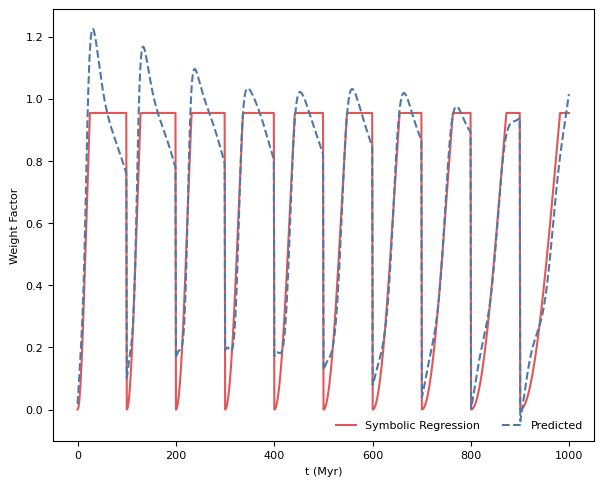

In [96]:
plt.plot(model.predict(sr_input), c='C2', label='Symbolic Regression')
plt.plot(weights_input, ls='--', label='Predicted')
plt.ylabel('Weight Factor')
plt.xlabel('t (Myr)')
plt.legend(frameon=False,handlelength=1.8, loc='lower right',ncols=2)
plt.show()

In [24]:
# input in code units
def get_sol_SR(r, steps=1000):
    cool_fac = 100
    g        = g_code_units
    chi      = 100
    t_end    = 225
    c0       = 1.0
    rho_cold = 100.0
    m0       = rho_cold*(4/3)*jnp.pi*r**3
    cshot    = 1.5*jnp.sqrt(chi/100)
    
    f_A      = 0.234
    tgrow0   = f_A*150*jnp.power(cool_fac/5,-0.25)*(chi/100)*r**0.75

    @jax.jit
    def falling_cloud(t,y,args):
        z,v,m = y
        
        rampup = (z/r)/(0.051146932/0.001)
        weight = jnp.where(rampup<0.95419395,rampup,0.95419395)
        tgrow = 1./weight*tgrow0*jnp.power(m/m0,1/6)*jnp.power(1.5/jnp.where(v<cshot,v,cshot),0.6)

        dzdt = v
        dvdt = -(v/tgrow) + g - ((c0)/(2*chi))*(1/r)*v**2
        dmdt = m/tgrow

        return dzdt, dvdt, dmdt

    term   = ODETerm(falling_cloud)
    solver = Tsit5()
    saveat = SaveAt(ts=jnp.linspace(0, t_end, steps))
    sol    = diffeqsolve(term, solver, 0, t_end, 0.1, (1e-20,1e-20,m0), args=(), saveat=saveat)
    
    return jnp.array(sol.ys)

In [25]:
training_sol_SR = jax.vmap(get_sol_SR)(rs)
test_sol_SR     = jax.vmap(get_sol_SR)(rsT)

ys_SR = jax.vmap(normalize2,0)(training_sol_SR)
ysT_SR = jax.vmap(normalize2,0)(test_sol_SR) 

def get_weight_SR(r,z):
    chi = 100
    rampup = (z/r)/(0.051146932/0.001)
    weight = jnp.where(rampup<0.95419395,rampup,0.95419395)
    return weight

actual_weights1_SR = get_weight_SR(rs[0],  1000*ys_SR[0,:,1])
actual_weights2_SR = get_weight_SR(rs[1],  1000*ys_SR[1,:,1])
actual_weights3_SR = get_weight_SR(rs[2],  1000*ys_SR[2,:,1])
actual_weightsT_SR = get_weight_SR(rsT[0], 1000*ysT_SR[0,:,1]) 

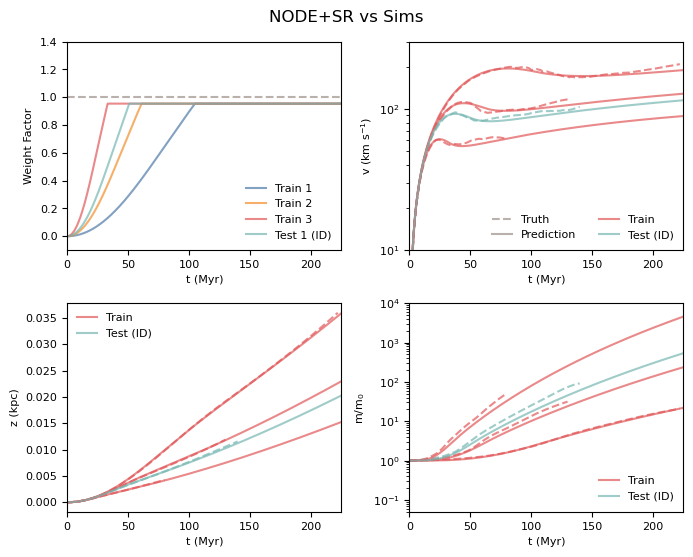

In [26]:
 # Create plots
latexify(columns=2)
fig, axs = plt.subplots(2, 2)

axs[0][0].hlines(1,0,225,ls='--',color='C9')
axs[0][0].plot(t_range, actual_weights1_SR,  c='C0', alpha=0.7, ls = '-',  label=r'Train 1')
axs[0][0].plot(t_range, actual_weights2_SR,  c='C1', alpha=0.7, ls = '-',  label=r'Train 2') 
axs[0][0].plot(t_range, actual_weights3_SR,  c='C2', alpha=0.7, ls = '-',  label=r'Train 3') 
axs[0][0].plot(t_range, actual_weightsT_SR,  c='C3', alpha=0.7, ls = '-',  label=r'Test 1 (ID)') 
axs[0][0].set_ylabel('Weight Factor')
axs[0][0].set_xlabel('t (Myr)')
axs[0][0].set_xlim([0,t_end])
axs[0][0].set_ylim([-0.1,1.4])
axs[0][0].legend(frameon=False,handlelength=1.8, loc='lower right', ncols=1)

axs[0][1].plot(-100, -100, c='C9', ls= '--', label='Truth')
axs[0][1].plot(-100, -100, c='C9', ls= '-', label='Prediction')
axs[0][1].plot(train_ts[0], 100*train_ys[0,:,0],alpha=0.7,c='C2',ls='--')
axs[0][1].plot(train_ts[1], 100*train_ys[1,:,0],alpha=0.7,c='C2',ls='--')
axs[0][1].plot(train_ts[2], 100*train_ys[2,:,0],alpha=0.7,c='C2',ls='--')
axs[0][1].plot(test_ts[0],  100*test_ys[0,:,0], alpha=0.7,c='C3',ls='--')
axs[0][1].plot(t_range, 100*ys_SR[0,:,0],alpha=0.7,label="Train",c='C2')
axs[0][1].plot(t_range, 100*ys_SR[1,:,0],alpha=0.7,c='C2')
axs[0][1].plot(t_range, 100*ys_SR[2,:,0],alpha=0.7,c='C2')
axs[0][1].plot(t_range, 100*ysT_SR[0,:,0],alpha=0.7,label="Test (ID)",c='C3')

axs[0][1].set_xlim([0,t_end])
axs[0][1].set_yscale('log')
axs[0][1].set_ylim([0.1*100, 3*100])
axs[0][1].set_xlabel('t (Myr)')
axs[0][1].set_ylabel(r'v (km s$^{-1}$)')
axs[0][1].legend(frameon=False,handlelength=1.8,loc='lower right',ncols=2)

axs[1][0].plot(train_ts[0], train_ys[0,:,1]/10,alpha=0.7,c='C2',ls='--')
axs[1][0].plot(train_ts[1], train_ys[1,:,1]/10,alpha=0.7,c='C2',ls='--')
axs[1][0].plot(train_ts[2], train_ys[2,:,1]/10,alpha=0.7,c='C2',ls='--')
axs[1][0].plot(test_ts[0] , test_ys[0,:,1]/10 ,alpha=0.7,c='C3',ls='--')
axs[1][0].plot(t_range, ys_SR[0,:,1]/10,alpha=0.7,label="Train",c='C2')
axs[1][0].plot(t_range, ys_SR[1,:,1]/10,alpha=0.7,c='C2')
axs[1][0].plot(t_range, ys_SR[2,:,1]/10,alpha=0.7,c='C2')
axs[1][0].plot(t_range, ysT_SR[0,:,1]/10,alpha=0.7,label="Test (ID)",c='C3')
axs[1][0].set_xlim([0,t_end])
axs[1][0].set_xlabel('t (Myr)')
axs[1][0].set_ylabel('z (kpc)')
axs[1][0].legend(frameon=False,handlelength=1.8, loc='upper left',ncols=1)

axs[1][1].plot(train_ts[0], train_ys[0,:,2]/train_ys[0,0,2],alpha=0.7,c='C2',ls='--')
axs[1][1].plot(train_ts[1], train_ys[1,:,2]/train_ys[1,0,2],alpha=0.7,c='C2',ls='--')
axs[1][1].plot(train_ts[2], train_ys[2,:,2]/train_ys[2,0,2],alpha=0.7,c='C2',ls='--')
axs[1][1].plot(test_ts[0], test_ys[0,:,2]/test_ys[0,0,2],alpha=0.7,c='C3',ls='--')
axs[1][1].plot(t_range, ys_SR[0,:,2]/ys_SR[0,0,2],alpha=0.7,label="Train",c='C2')
axs[1][1].plot(t_range, ys_SR[1,:,2]/ys_SR[1,0,2],alpha=0.7,c='C2')
axs[1][1].plot(t_range, ys_SR[2,:,2]/ys_SR[2,0,2],alpha=0.7,c='C2')
axs[1][1].plot(t_range, ysT_SR[0,:,2]/ysT_SR[0,0,2],alpha=0.7,label="Test (ID)",c='C3')
axs[1][1].set_yscale('log')
axs[1][1].set_xlim([0,t_end])
axs[1][1].set_ylim([0.05,10000])
axs[1][1].set_xlabel('t (Myr)')
axs[1][1].set_ylabel(r'm/m$_0$')
axs[1][1].legend(frameon=False,handlelength=1.8, loc='lower right',ncols=1)
axs[1][1].set_yscale('log')
axs[1][1].set_xlim([0,t_end])
axs[1][1].set_ylim([0.05,10000])
axs[1][1].set_xlabel('t (Myr)')
axs[1][1].set_ylabel(r'm/m$_0$')
axs[1][1].legend(frameon=False,handlelength=1.8, loc='lower right',ncols=1)

plt.suptitle("NODE+SR vs Sims")
plt.tight_layout()
plt.savefig('./plots/node_sr_sims.png',dpi=150)
plt.savefig('./plots/node_sr_sims.pdf',dpi=150)
plt.show()